In [1]:
!pip install simpletransformers

  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [3]:
def preprocess(data):
  data.insert(0, 'sentence', np.nan)
  indexes = data.index[data['word']=='।'].tolist()

  val = 0
  for id in indexes:
    data.loc[data.index[id], 'sentence'] = val
    val = val+1

  data =data.fillna(method ="bfill")
  data["sentence"] = LabelEncoder().fit_transform(data["sentence"])

  data.rename(columns={"sentence":"sentence_id","word":"words","O_BI":"labels"}, inplace =True)
  data["labels"] = data["labels"].str.upper()

  return data



In [4]:
# data = pd.read_csv("/content/train_up_ner.csv",encoding="latin1" )
data = pd.read_csv("/content/train_data_ner.csv")
data_test = pd.read_csv("/content/test_data_ner.csv")

data = preprocess(data)
data_test = preprocess(data_test)

data.head(10)

,sentence_id,words,labels
0,0,কী,O
1,0,কারণে,O
2,0,তাঁদের,O
3,0,মধ্যে,O
4,0,ঝামেলা,O
5,0,হয়েছে,O
6,0,তা,O
7,0,জানি,O
8,0,না।,O
9,0,বরুড়া,B-LOC


In [5]:
data_test.isnull().sum()

sentence_id    0
words          0
labels         0
dtype: int64

In [6]:
labels = data["labels"].unique().tolist()
print(labels)

data["labels"].value_counts()

['O', 'B-LOC', 'B-PER', 'I-PER', 'I-ORG', 'B-ORG', 'TIM', 'I-LOC']


O        55551
B-PER     1846
I-PER     1614
TIM       1609
B-ORG     1391
B-LOC     1322
I-ORG      908
I-LOC      204
Name: labels, dtype: int64

Text(0.5, 1.0, 'Distribution of classes')

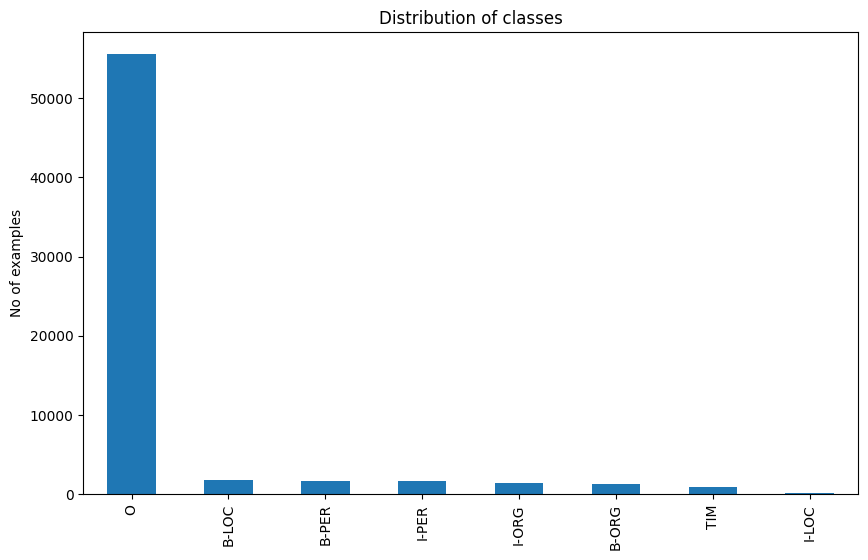

In [7]:
plt.figure(figsize=(10, 6))
data['labels'].value_counts().plot(kind='bar')
plt.xticks(np.arange(len(labels)),labels)
plt.ylabel("No of examples")
plt.title("Distribution of classes")

In [8]:
def remove_punctuations_and_stopwords(df):
  punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰'''
  data1 =pd.read_excel('stopwords_bangla.xlsx')
  stop_words = data1['words'].tolist()

  data = df.copy()
  count = 0
  for word in data['words']:
    m_word = ""
    for char in word:
        if char not in punctuations:
            m_word = m_word + char
    print(m_word)
    if len(m_word) == 0:
        data.drop(data[data['words'] == word].index, inplace=True)
    else:
        data.replace(word, m_word, inplace=True)

    if word in stop_words:
      data.drop(data[data['words'] == word].index, inplace=True)

  # print(len(data))
  return data
  # for word in data['words']:
  #   if str(word) in punctuations or str(word) in stop_words:
  #     # print(word)
  #     data.drop(data[data['words']==word].index, inplace=True)

  # print(len(data))
  # return data

In [9]:
print(len(data))
# data = remove_punctuations_and_stopwords(data)
# data['labels'].value_counts()


64445


In [10]:
data.head(10)

,sentence_id,words,labels
0,0,কী,O
1,0,কারণে,O
2,0,তাঁদের,O
3,0,মধ্যে,O
4,0,ঝামেলা,O
5,0,হয়েছে,O
6,0,তা,O
7,0,জানি,O
8,0,না।,O
9,0,বরুড়া,B-LOC


In [11]:
data1 =pd.read_excel('stopwords_bangla.xlsx')
stop_words = data1['words'].tolist()
stop_words[:10]

['অই',
 'অগত্যা',
 'অত: পর',
 'অতএব',
 'অথচ',
 'অথবা',
 'অধিক',
 'অধীনে',
 'অধ্যায়',
 'অনুগ্রহ']

In [12]:
X_train = data[["sentence_id","words"]]
Y_train = data["labels"]

X_test = data_test[["sentence_id","words"]]
Y_test = data_test["labels"]

In [13]:
train_data = pd.DataFrame({"sentence_id":X_train["sentence_id"],"words":X_train["words"],"labels":Y_train})
test_data = pd.DataFrame({"sentence_id":X_test["sentence_id"],"words":X_test["words"],"labels":Y_test})

In [14]:
from simpletransformers.ner import NERModel,NERArgs

In [15]:
label = data["labels"].unique().tolist()
label

['O', 'B-LOC', 'B-PER', 'I-PER', 'I-ORG', 'B-ORG', 'TIM', 'I-LOC']

In [16]:
args = NERArgs()
args.num_train_epochs = 20
args.learning_rate = 1e-4
args.overwrite_output_dir =True
args.train_batch_size = 32
args.eval_batch_size = 32

In [18]:
# model = NERModel('bert', 'bert-base-cased',labels=label,args =args)
model = NERModel('bert', "sagorsarker/bangla-bert-base",labels=label,args =args)
# model = NERModel('bert', 'csebuetnlp/banglabert', labels=label,args =args)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and a

In [19]:
model.train_model(train_data,eval_data = test_data,acc=accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Saving vocabulary to outputs/checkpoint-145-epoch-1/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-145-epoch-1/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-145-epoch-1/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not c

Running Epoch 1 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-290-epoch-2/vocab.txt: vocabulary in

Running Epoch 2 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-435-epoch-3/vocab.txt: vocabulary in

Running Epoch 3 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-580-epoch-4/vocab.txt: vocabulary in

Running Epoch 4 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-725-epoch-5/vocab.txt: vocabulary in

Running Epoch 5 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-870-epoch-6/vocab.txt: vocabulary in

Running Epoch 6 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1015-epoch-7/vocab.txt: vocabu

Running Epoch 7 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1160-epoch-8/vocab.txt: vocabu

Running Epoch 8 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1305-epoch-9/vocab.txt: vocabu

Running Epoch 9 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1450-epoch-10/vocab.txt:

Running Epoch 10 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1595-epoch-11/vocab.txt:

Running Epoch 11 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1740-epoch-12/vocab.txt:

Running Epoch 12 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-1885-epoch-13/vocab.txt:

Running Epoch 13 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2000/vocab.txt: vocabulary indices are not consecutive. Please check that the 

Running Epoch 14 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2175-epoch-15/vocab.txt:

Running Epoch 15 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2320-epoch-16/vocab.txt:

Running Epoch 16 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2465-epoch-17/vocab.txt:

Running Epoch 17 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2610-epoch-18/vocab.txt:

Running Epoch 18 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2755-epoch-19/vocab.txt:

Running Epoch 19 of 20:   0%|          | 0/145 [00:00<?, ?it/s]

Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to outputs/checkpoint-2900-epoch-20/vocab.txt:

(2900, 0.04053795062745974)

In [20]:
result, model_outputs, preds_list = model.eval_model(test_data)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: TIM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [21]:
print(result)

{'eval_loss': 0.46412754996169, 'precision': 0.7634763476347635, 'recall': 0.6737864077669903, 'f1_score': 0.7158329035585353}


In [22]:
prediction, model_output = model.predict(["আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম"])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
prediction

[[{'আব্দুর': 'B-PER'},
  {'রহিম': 'I-PER'},
  {'নামের': 'O'},
  {'কাস্টমারকে': 'O'},
  {'একশ': 'O'},
  {'টাকা': 'O'},
  {'বাকি': 'O'},
  {'দিলাম': 'O'}]]

In [24]:
model_output

[[{'আব্দুর': [[-3.002,
     -1.139,
     10.86,
     0.3164,
     -1.844,
     -2.625,
     -0.1079,
     -0.2932]]},
  {'রহিম': [[-2.385, -1.054, -0.3262, 9.94, -2.717, -2.37, -0.5723, -0.1142]]},
  {'নামের': [[12.17, -2.406, -1.201, -2.371, -2.76, -1.002, -3.63, -1.596]]},
  {'কাস্টমারকে': [[11.26,
     -3.258,
     -0.8984,
     -2.531,
     -1.998,
     -0.735,
     -1.331,
     -2.568],
    [12.055, -0.9634, -1.278, -1.949, -2.117, -2.5, -3.963, -1.486]]},
  {'একশ': [[12.18, -1.97, -1.272, -2.514, -2.463, -1.568, -3.445, -1.748]]},
  {'টাকা': [[12.336, -1.528, -2.895, -1.842, -2.32, -1.746, -3.05, -1.921]]},
  {'বাকি': [[11.4, -2.303, -1.543, -1.62, -3.314, -1.3, -1.65, -1.688]]},
  {'দিলাম': [[11.42, -2.725, -1.234, -1.419, -2.86, -1.262, -3.322, -1.204]]}]]